In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
import matplotlib.font_manager as fm
import itertools
import statsmodels.api as sm 
import random
import datetime

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'retina'

# 개요

이 time 데이터는 배달 데이터와 관련지어 활용할 수 있을 것입니다. 예컨대, 확진자가 많아져 사회적 거리두기가 강화되면 사람들은 외식을 하지 못하니
배달량이 늘지 않았을까요? 또한, 대면형식으로 이루어지는 현금이나 카드 지불 방식보다는 선불 방식을 활용하지 않았을까요?
또한, 평소에도 자주 먹던 치킨 보다는 카페/디저트의 배달량이 급증하지 않았을까요? 이를 알아보기 위해 우선 
time 데이터 이용해서 누적 확진자가 아닌 하루 당 확진자를 구합니다. 


# 확진자 구하기

In [2]:
Time = pd.read_csv("./Data_KT/time.csv")
Time

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0
...,...,...,...,...,...,...,...
158,2020-06-26,0,1232315,1200885,12602,11172,282
159,2020-06-27,0,1243780,1211261,12653,11317,282
160,2020-06-28,0,1251695,1219975,12715,11364,282
161,2020-06-29,0,1259954,1228698,12757,11429,282


In [11]:
confirmed = list(Time['confirmed'])
increase = []
num = []
for i in range(len(confirmed)-1):
    increase.append(confirmed[i+1] - confirmed[i])
    num.append(i)


In [78]:
idx = pd.to_datetime(Time['date'])
idx = idx.head(-1) 
ts = Series(increase,idx)
t= ts.resample('W').sum()
m = ts.resample('M').sum()
d = ts.resample('D').sum()

In [79]:
df_confirmed_W = pd.DataFrame()
df_confirmed_W['W']=t
df_confirmed_M = pd.DataFrame()
df_confirmed_M['M'] = m
df_confirmed_D = pd.DataFrame()
df_confirmed_D['D'] = d

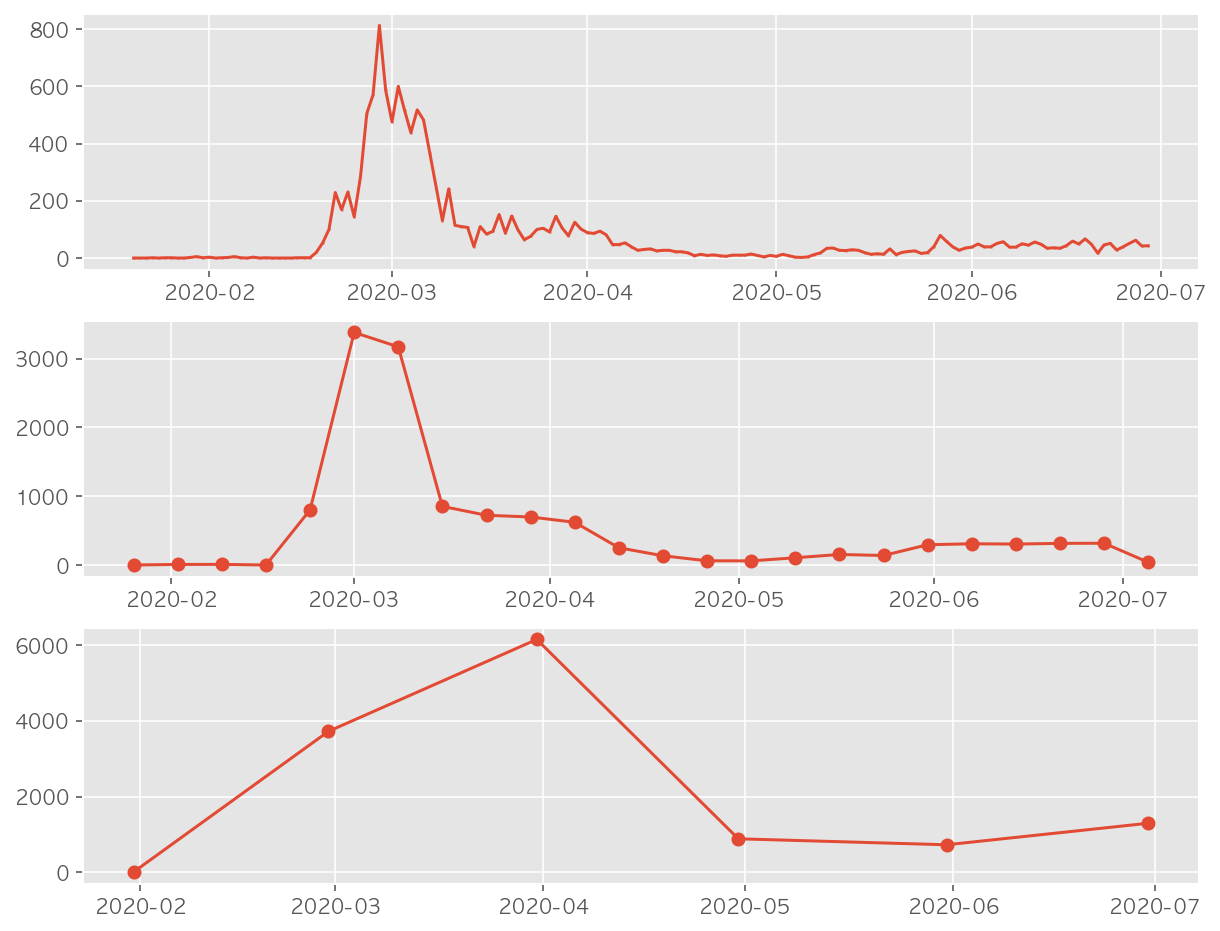

In [85]:
fig, ax = plt.subplots(3,1,figsize=(10,8))

ax[0].plot(df_confirmed_D.index, df_confirmed_D['D'], marker='o', markersize=0.2)
ax[1].plot(df_confirmed_W.index, df_confirmed_W['W'],marker='o')
ax[2].plot(df_confirmed_M.index, df_confirmed_M['M'],marker='o')

plt.show()

# Delivery data 활용

Delivery data 속 지불 방식에 관해 파헤쳐보고자 했습니다. 정부가 사회적 거리두기를 강화하고 이에 따라 여러 배달 업체들도 현금이나 카드 지불 방식이 아닌 선불 방식을 권유했으므로 이에 따른 선불 지불 방식의 변화가 있지 않을까 했습니다. 

In [4]:
delivery = pd.read_csv("./Data_KT/delivery.csv")
delivery

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158319,10672688,2020-06-21,C000312,1,C000312,S0029529,야식,4125010200,경기도,동두천시,...,D0013004,3000,500,26000,1,승인:하나카드,2020-06-21 22:48:22,2020-06-21 22:48:37,2020-06-21 23:07:47,NaN
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,...,D0006251,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN
5158321,10672690,2020-06-21,C000130,1,C000130,S0042234,야식,4128112300,경기도,고양시 덕양구,...,D0012754,3000,300,17000,2,NaN,2020-06-21 22:55:08,2020-06-21 22:55:22,2020-06-21 23:14:45,NaN
5158322,10672691,2020-06-21,C000237,1,C000237,S0021766,족발/보쌈,4121010200,경기도,광명시,...,D0004485,3630,200,53700,1,승인:비씨카드사,2020-06-21 23:10:38,2020-06-21 23:11:03,2020-06-21 23:25:10,NaN


우선, 배달데이터를 이용해 전체 선불 비율을 알아내고, 이를 보기좋게 파이플롯과 바플롯으로 시각화하였습니다.

In [5]:


delivery2 = delivery.groupby('SETLE_KND_VALUE').count()
delivery2['Ratio'] = delivery2['SERIAL_NUMBER']/5158324 *100
delivery2

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,Ratio
SETLE_KND_VALUE,,,,,,,,,,,,,,,,,,,,,
1,1614705,1614705,1614705,1614705,1595559,1614705,1614705,1614705,1614705,1614705,...,1614705,1614705,1614705,1614705,1588547,1614705,1595944,1589077,26900,31.302900
2,3022488,3022488,3022488,3022488,2986393,3022488,3022488,3022488,3022488,3022488,...,3022488,3022488,3022488,3022488,9747,3022488,2986961,2955326,46527,58.594381
3,521131,521131,521131,521131,513478,521131,521131,521131,521131,521131,...,521131,521131,521131,521131,18695,521131,513618,510681,10173,10.102719


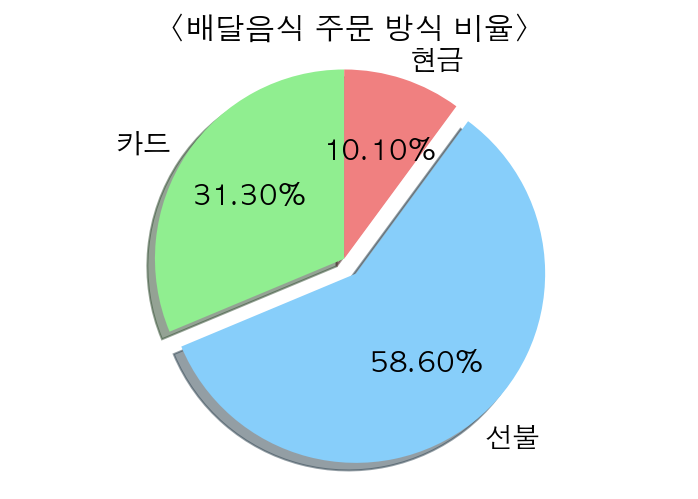

In [6]:

group_sizes= [31.3, 58.6, 10.1]
group_names = ['카드', '선불', '현금']
group_colors = ['lightgreen', 'lightskyblue', 'lightcoral']
group_explodes = (0,0.1, 0) # explode 1st slice

plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size

plt.axis('equal') #  equal length of X and Y axis

plt.title('<배달음식 주문 방식 비율>', fontsize=15)
%config InlineBackend.figure_format = 'retina'

plt.show()

이런식으로 1월것만 따로 뽑아서 바플롯으로 나타낼 수도 있었습니다. 

In [50]:
Setle_Knd_Value = delivery.loc[delivery['SETLE_KND_VALUE'] == 2]
Setle_Knd_Value

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,amount
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN,54000
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN,24800
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN,38800
6,4577994,2020-01-01,C000049,1,C000049,S0022461,분식,1153010800,서울특별시,구로구,...,3800,300,28000,2,NaN,2020-01-01 01:27:00,2020-01-01 01:27:47,2020-01-01 01:41:45,NaN,32100
7,4577995,2020-01-01,C000238,1,C000238,S0001037,야식,4119010200,경기도,부천시,...,3500,200,28500,2,NaN,2020-01-01 00:09:40,2020-01-01 00:17:31,2020-01-01 00:32:24,NaN,32200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158317,10672686,2020-06-21,C000285,1,C000285,S0039139,분식,4117310400,경기도,안양시 동안구,...,3300,300,13000,2,NaN,2020-06-21 23:42:11,2020-06-21 23:42:25,2020-06-21 23:48:58,NaN,16600
5158318,10672687,2020-06-21,C000130,1,C000130,S0002269,분식,4128112300,경기도,고양시 덕양구,...,3500,300,25000,2,NaN,2020-06-21 23:12:17,2020-06-21 23:12:31,2020-06-21 23:19:24,NaN,28800
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,...,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN,25655
5158321,10672690,2020-06-21,C000130,1,C000130,S0042234,야식,4128112300,경기도,고양시 덕양구,...,3000,300,17000,2,NaN,2020-06-21 22:55:08,2020-06-21 22:55:22,2020-06-21 23:14:45,NaN,20300


In [51]:
Setle_Knd_Value2 = delivery.loc[delivery['SETLE_KND_VALUE'] == 1]
Setle_Knd_Value2
Setle_Knd_Value2= Setle_Knd_Value2.groupby('PROCESS_DT')['SETLE_KND_VALUE'].sum().reset_index()
Setle_Knd_Value2

,PROCESS_DT,SETLE_KND_VALUE
0,2020-01-01,9220
1,2020-01-02,6438
2,2020-01-03,7941
3,2020-01-04,9304
4,2020-01-05,8921
...,...,...
160,2020-06-10,11836
161,2020-06-11,10709
162,2020-06-12,12298
163,2020-06-20,13264


In [52]:
Setle_Knd_Value3 = delivery.loc[delivery['SETLE_KND_VALUE'] == 3]
Setle_Knd_Value3
Setle_Knd_Value3= Setle_Knd_Value3.groupby('PROCESS_DT')['SETLE_KND_VALUE'].sum().reset_index()
Setle_Knd_Value3

,PROCESS_DT,SETLE_KND_VALUE
0,2020-01-01,9642
1,2020-01-02,8358
2,2020-01-03,9078
3,2020-01-04,10473
4,2020-01-05,10482
...,...,...
160,2020-06-10,8676
161,2020-06-11,8085
162,2020-06-12,9429
163,2020-06-20,10740


In [53]:
Setle_Knd_Value= Setle_Knd_Value.groupby('PROCESS_DT')['SETLE_KND_VALUE'].sum().reset_index()
Setle_Knd_Value

,PROCESS_DT,SETLE_KND_VALUE
0,2020-01-01,36838
1,2020-01-02,25228
2,2020-01-03,29922
3,2020-01-04,34440
4,2020-01-05,37638
...,...,...
160,2020-06-10,38810
161,2020-06-11,35880
162,2020-06-12,41664
163,2020-06-20,50072


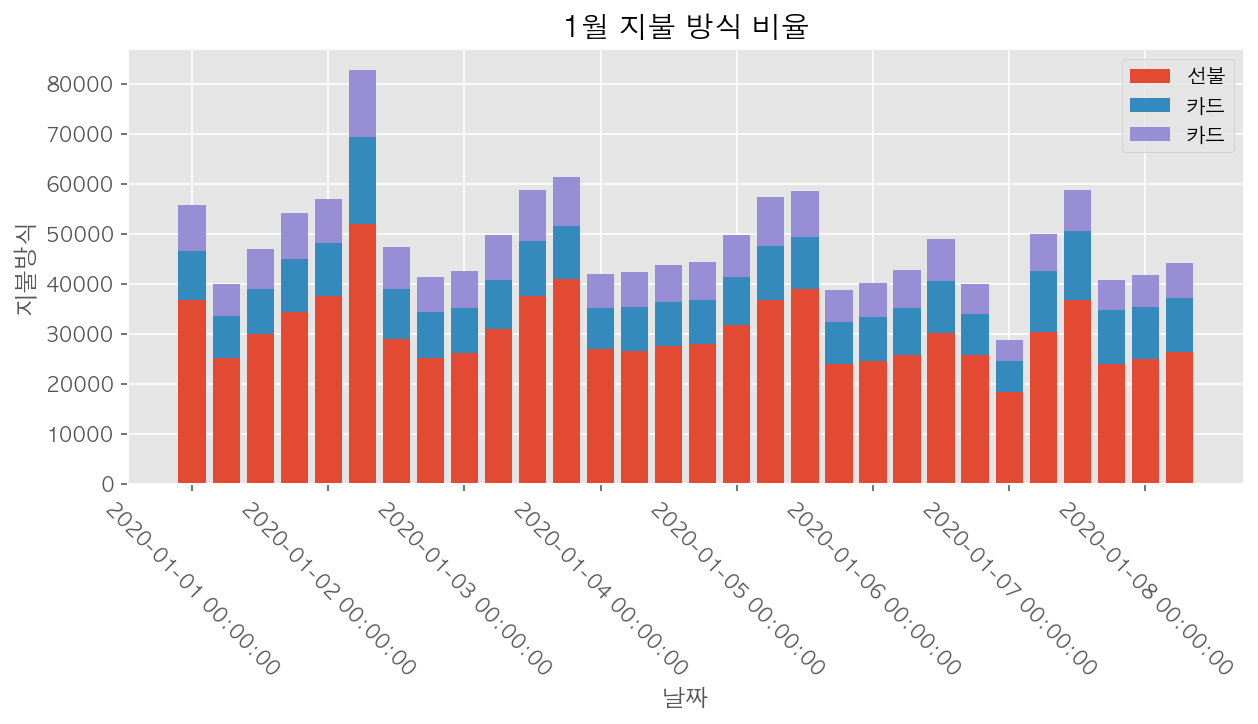

In [54]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(Setle_Knd_Value['PROCESS_DT'][:30],Setle_Knd_Value['SETLE_KND_VALUE'][:30], label='선불')
ax.bar(Setle_Knd_Value3['PROCESS_DT'][:30],Setle_Knd_Value3['SETLE_KND_VALUE'][:30], bottom=Setle_Knd_Value['SETLE_KND_VALUE'][:30],label='카드')
ax.bar(Setle_Knd_Value2['PROCESS_DT'][:30],Setle_Knd_Value2['SETLE_KND_VALUE'][:30], 
       bottom=Setle_Knd_Value['SETLE_KND_VALUE'][:30] + Setle_Knd_Value3['SETLE_KND_VALUE'][:30],label='카드')

ax.set_xticklabels(Setle_Knd_Value['PROCESS_DT'], rotation=-45)
ax.set_xlabel('날짜')
ax.set_ylabel('지불방식')
ax.set_title('1월 지불 방식 비율')
ax.legend()
plt.show()



그렇다면 선불지불방식은 코로나가 심해짐에 따라 비율이 증가했을까요? 그건 아닌듯 합니다. 다만, 선불 지불 방식을 더 유용하고 효과적으로 사용하는 소비자들이 증가하고 있다고 판단할 수 있으므로 배달업체는 페이 수단을 늘이거나 페이 가맹 업체를 늘리는 등 소비자의 욕구를 충족시켜줄 수 있어야 할 것입니다. 

In [56]:
#코로나가 심해짐에 따라 변화가 있는지 보기 위해 시계열 데이터로 바꾸어줍니다. 

Setle_Knd_Value['PROCESS_DT'] = Setle_Knd_Value['PROCESS_DT'].astype('datetime64[ns]')
idx = pd.to_datetime(Setle_Knd_Value['PROCESS_DT'])
idx

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
160   2020-06-10
161   2020-06-11
162   2020-06-12
163   2020-06-20
164   2020-06-21
Name: PROCESS_DT, Length: 165, dtype: datetime64[ns]

In [57]:
a = list(Setle_Knd_Value['SETLE_KND_VALUE'])
ts = Series(a, idx)
y = ts.resample('M').mean()
z = ts.resample('W').mean()
w= ts.resample('D').mean()


In [58]:
df= pd.DataFrame()
df['mean of Advanced payment'] = y
df2 =pd.DataFrame()
df2['mean of Advanced payment'] = z
df3=pd.DataFrame()
df3['Advanced payment']=w



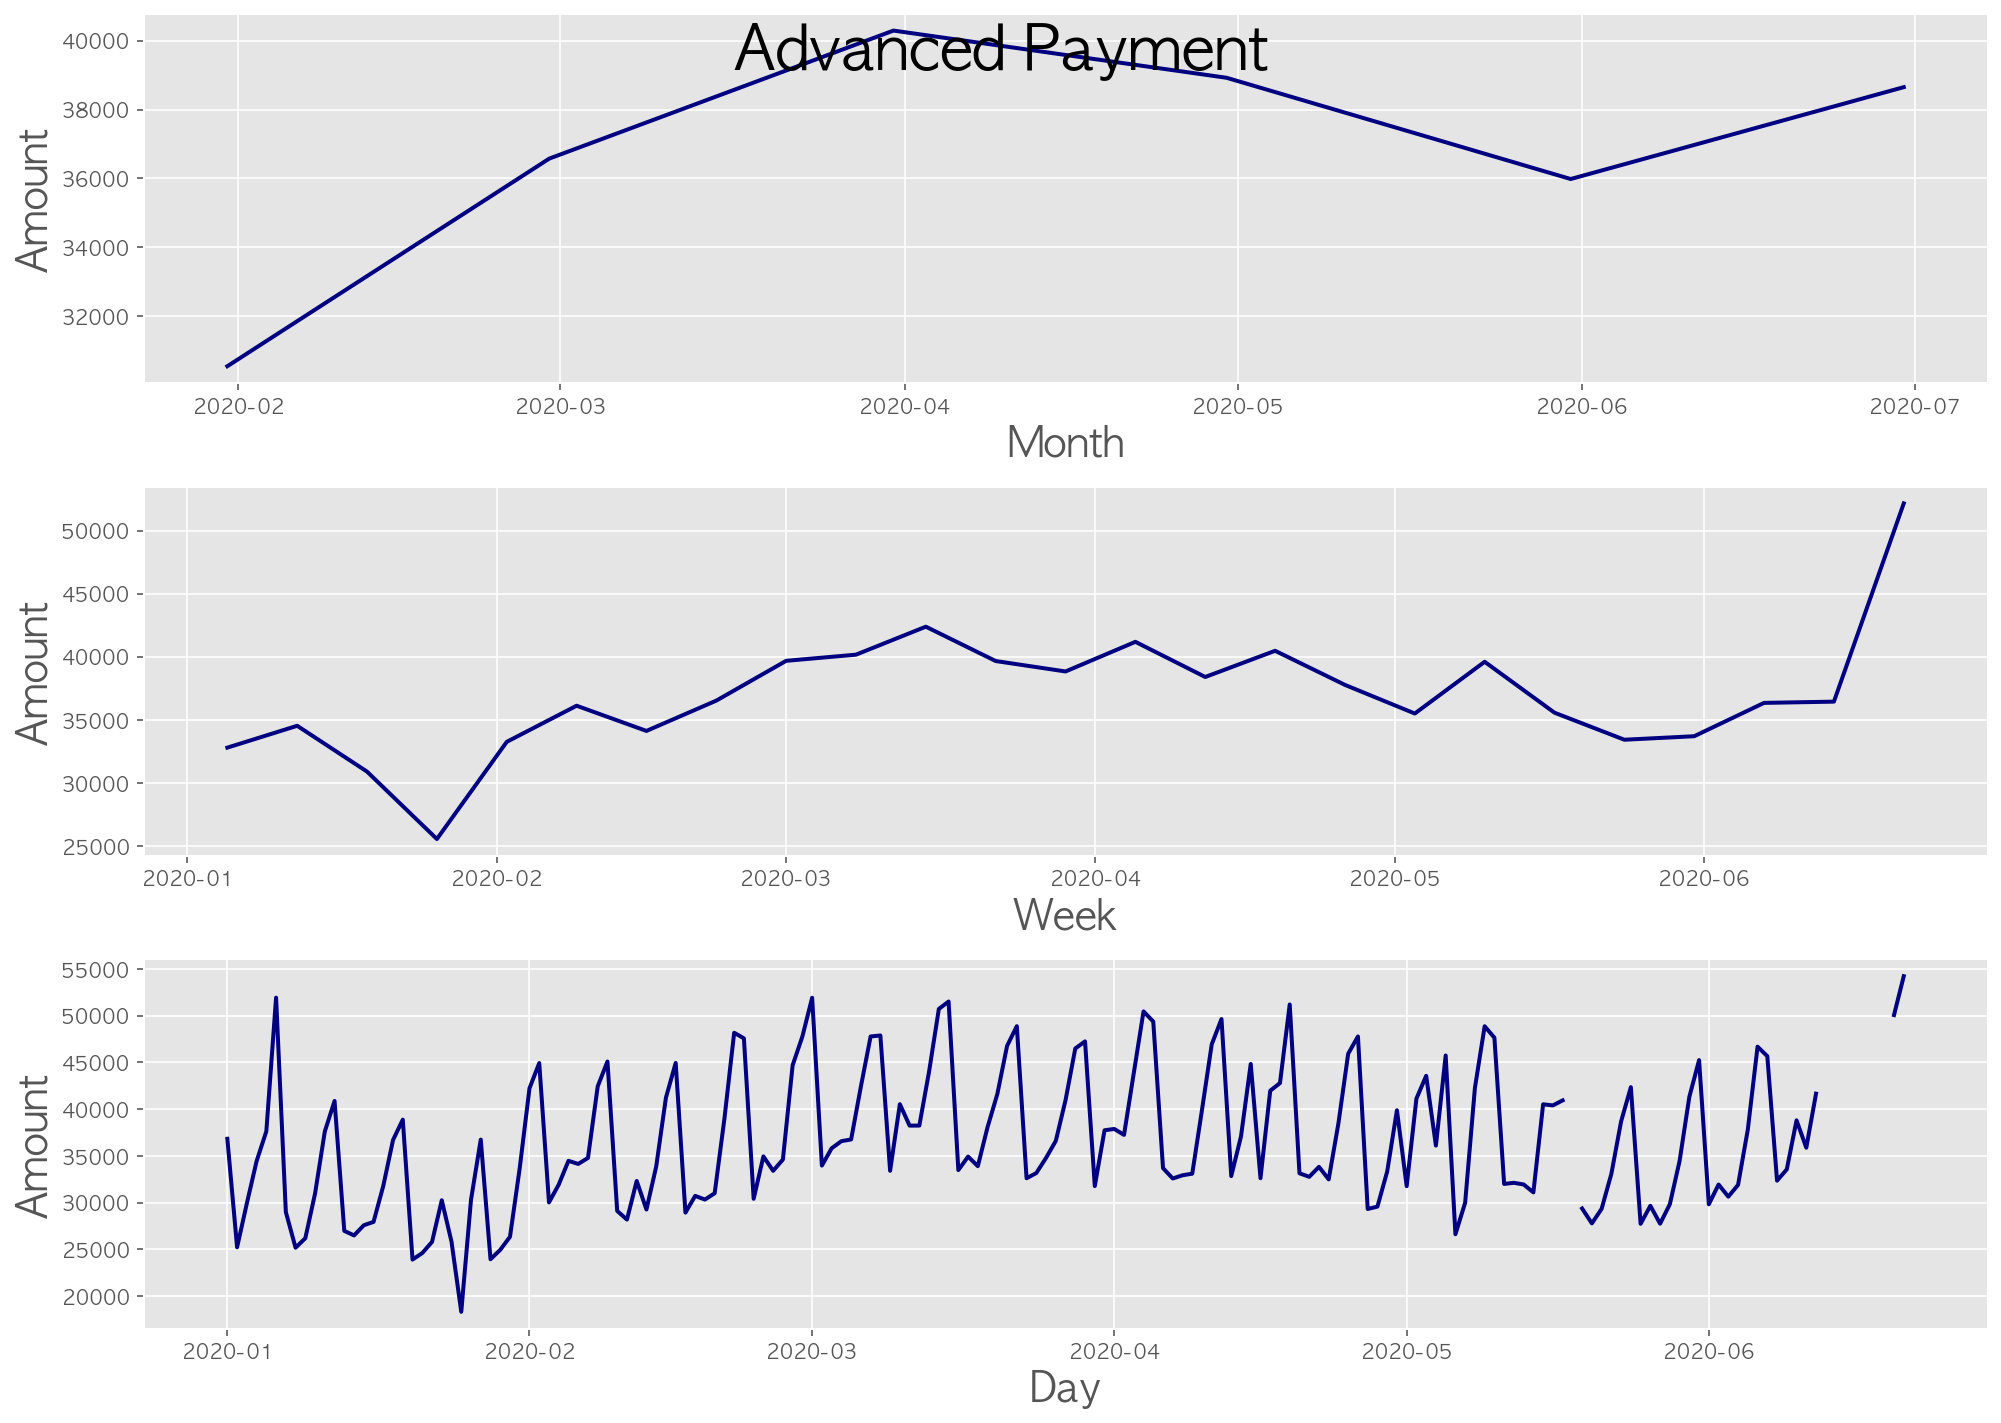

In [67]:
fig, ax = plt.subplots(3,1)
ax[0].plot(df.index, df['mean of Advanced payment'] , linewidth=2, color='navy')
ax[0].set_xlabel('Month', fontsize=20)
ax[0].set_ylabel('Amount', fontsize=20)

ax[1].plot(df2.index, df2['mean of Advanced payment'],linewidth=2, color='navy')
ax[1].set_xlabel('Week', fontsize=20)
ax[1].set_ylabel('Amount', fontsize=20)


ax[2].plot(df3.index, df3['Advanced payment'], linewidth=2, color='navy')
plt.xlabel('Day', fontsize=20)
plt.ylabel('Amount', fontsize=20)

plt.suptitle('Advanced Payment', fontsize= 30, zorder = 30)
plt.tight_layout()
plt.show()

정부 정책에 따른 변화가 있을까요?

In [68]:
policy = pd.read_csv("./Data_KT/Policy.csv")
policy_sd = policy.loc[policy['type']=='Social']
idx = pd.to_datetime(policy_sd['start_date'])
a = list(policy_sd['detail'])
ts = Series(a, idx)

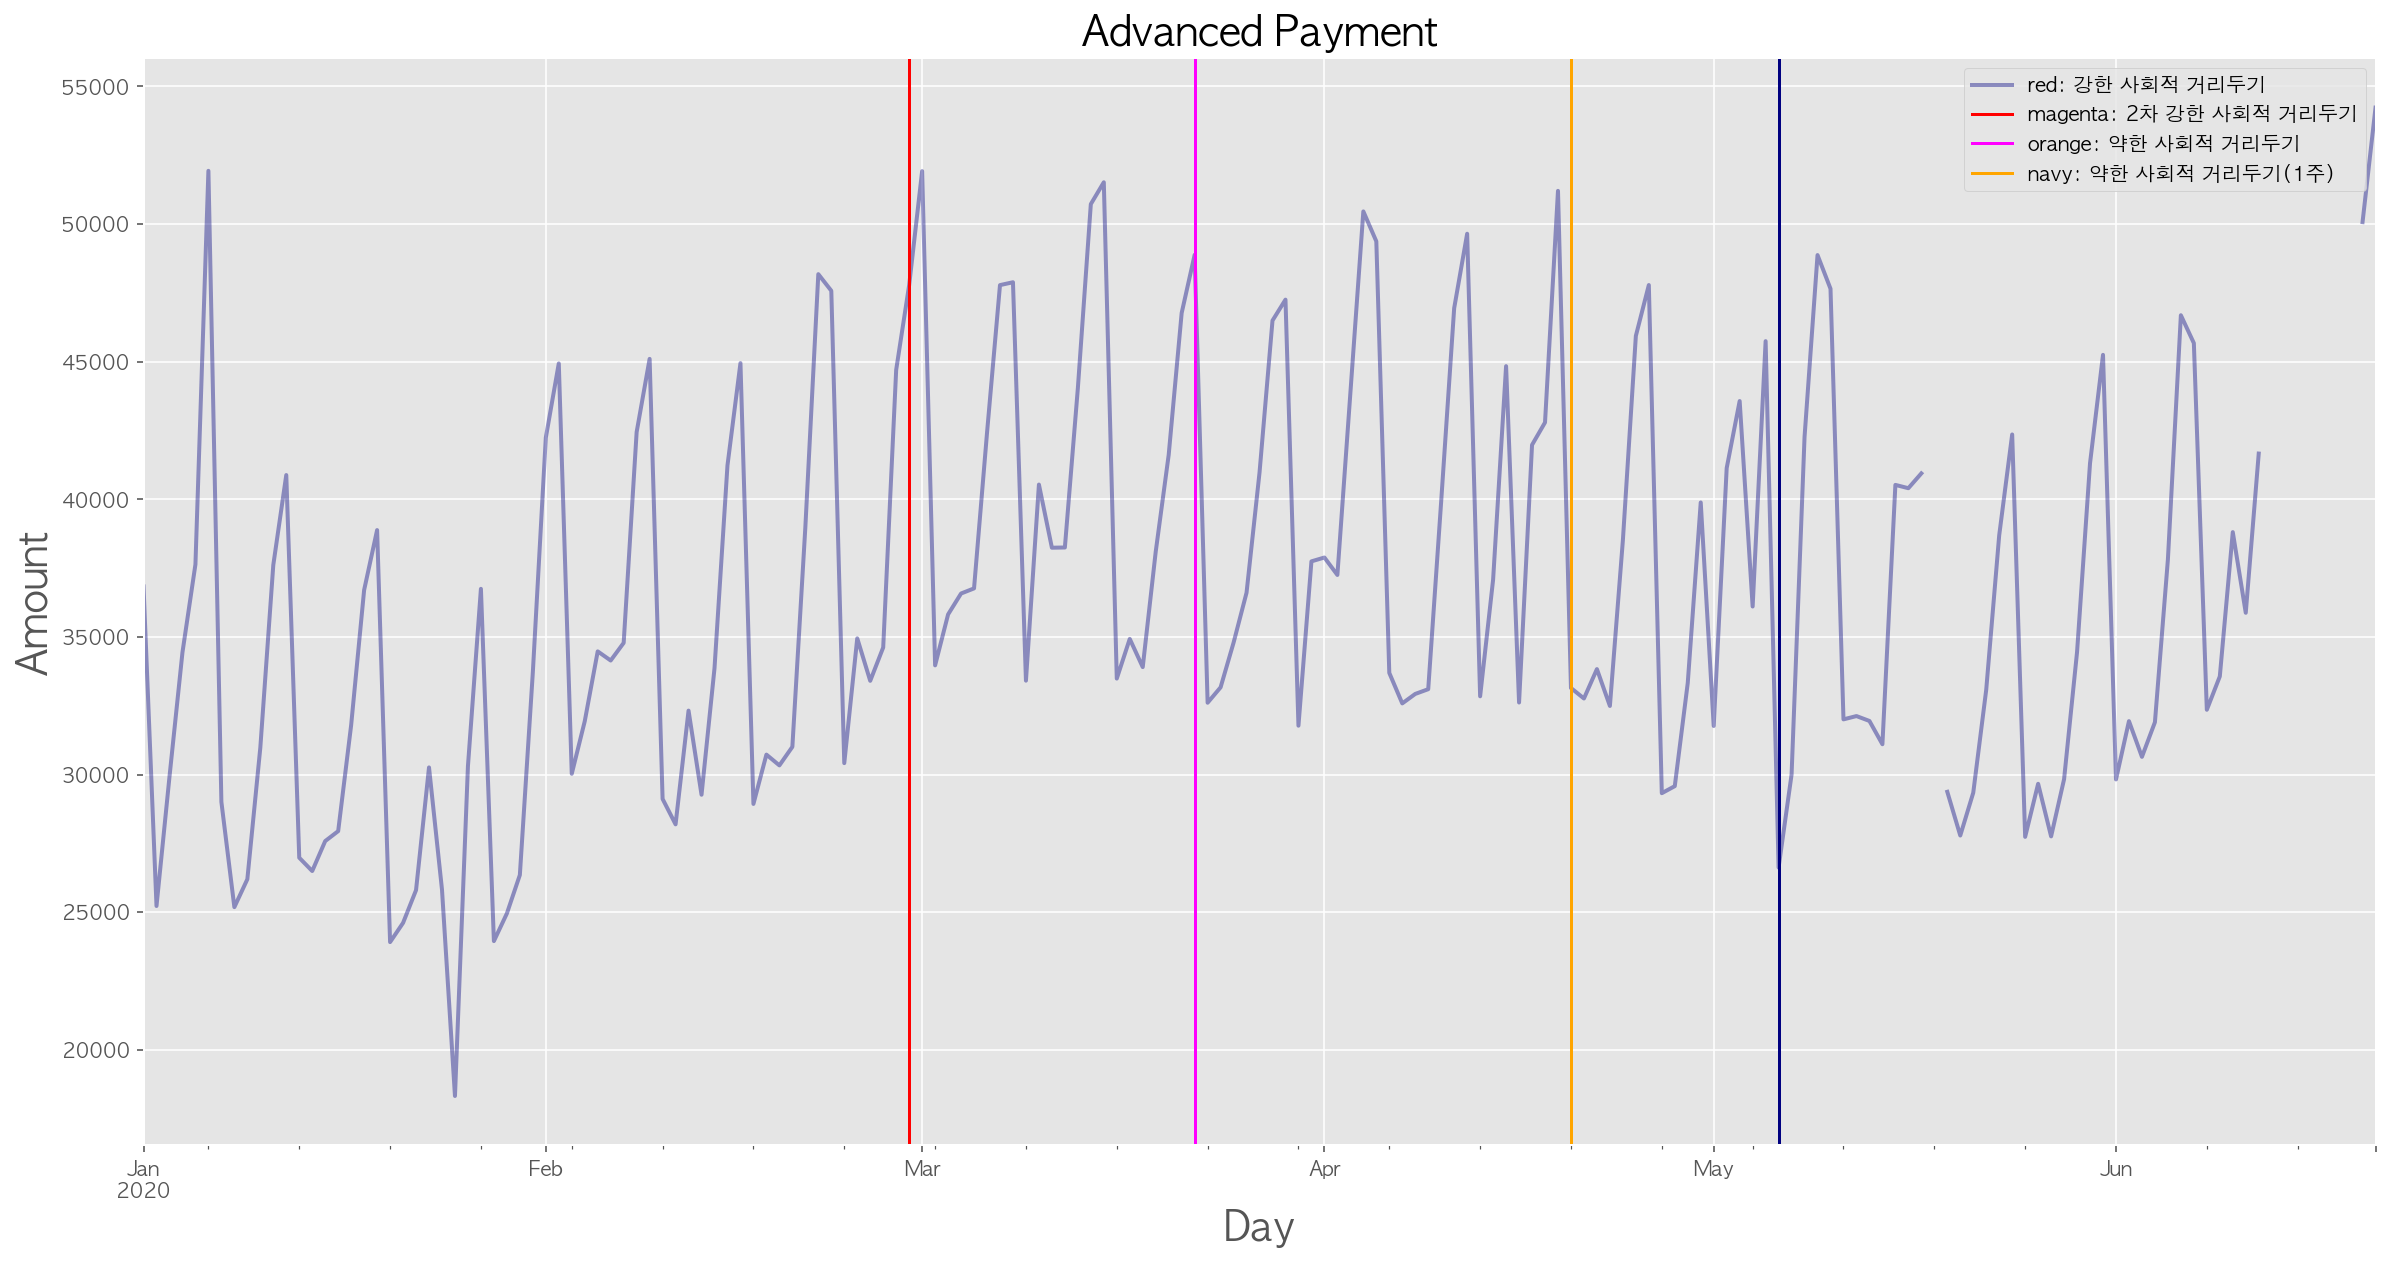

In [69]:
df3.plot(figsize = (20,10), linewidth=2, color='navy', alpha=0.4)
plt.title('Advanced Payment', fontsize= 20)
plt.xlabel('Day', fontsize=20)
plt.ylabel('Amount', fontsize=20)

plt.axvline(x='2020-02-29',color='red')
plt.axvline(x='2020-03-22',color='magenta', linestyle='-')
plt.axvline(x='2020-04-20', color='orange')
plt.axvline(x='2020-05-06', color='navy')

plt.legend(['red: 강한 사회적 거리두기', 'magenta: 2차 강한 사회적 거리두기', 'orange: 약한 사회적 거리두기','navy: 약한 사회적 거리두기(1주)'])
plt.show()

코로나가 심해지고 policy가 변함에 따라(사회적 거리두기 강화, 약화 등)와 배달총매출은 어떻게 변화하는지 알아보고자 했습니다. 이를 위해 PROCESS_DT를 시계열 데이터로 바꾸어줍니다. 

In [7]:
delivery

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158319,10672688,2020-06-21,C000312,1,C000312,S0029529,야식,4125010200,경기도,동두천시,...,D0013004,3000,500,26000,1,승인:하나카드,2020-06-21 22:48:22,2020-06-21 22:48:37,2020-06-21 23:07:47,NaN
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,...,D0006251,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN
5158321,10672690,2020-06-21,C000130,1,C000130,S0042234,야식,4128112300,경기도,고양시 덕양구,...,D0012754,3000,300,17000,2,NaN,2020-06-21 22:55:08,2020-06-21 22:55:22,2020-06-21 23:14:45,NaN
5158322,10672691,2020-06-21,C000237,1,C000237,S0021766,족발/보쌈,4121010200,경기도,광명시,...,D0004485,3630,200,53700,1,승인:비씨카드사,2020-06-21 23:10:38,2020-06-21 23:11:03,2020-06-21 23:25:10,NaN


In [8]:
delivery['amount'] = delivery['DLVR_AMOUNT']+ delivery['CALL_RLAY_FEE_AMOUNT']+delivery2['GOODS_AMOUNT']

In [9]:
delivery['DLVR_STORE_INDUTY_NM'].unique()
delivery.groupby('DLVR_STORE_INDUTY_NM')

In [27]:
delivery['PROCESS_DT'] = delivery['PROCESS_DT'].astype('datetime64[ns]')
idx = pd.to_datetime(delivery['PROCESS_DT'])
idx
a = list(delivery['amount'])
ts = Series(a, idx)
y = ts.resample('M').mean()
z = ts.resample('W').mean()

df= pd.DataFrame()
df2 = pd.DataFrame()

df['Delivery amount(mean) by Month '] = y
df2['Delivery amount(mean) by Week'] =z 

Amount = df['Delivery amount(mean) by Month '].to_numpy()
Amount2 = df2['Delivery amount(mean) by Week'].to_numpy()

df


,Delivery amount(mean) by Month
PROCESS_DT,
2020-01-31,27062.863331
2020-02-29,27214.170198
2020-03-31,27510.911026
2020-04-30,27685.953173
2020-05-31,27936.280204
2020-06-30,27508.463405


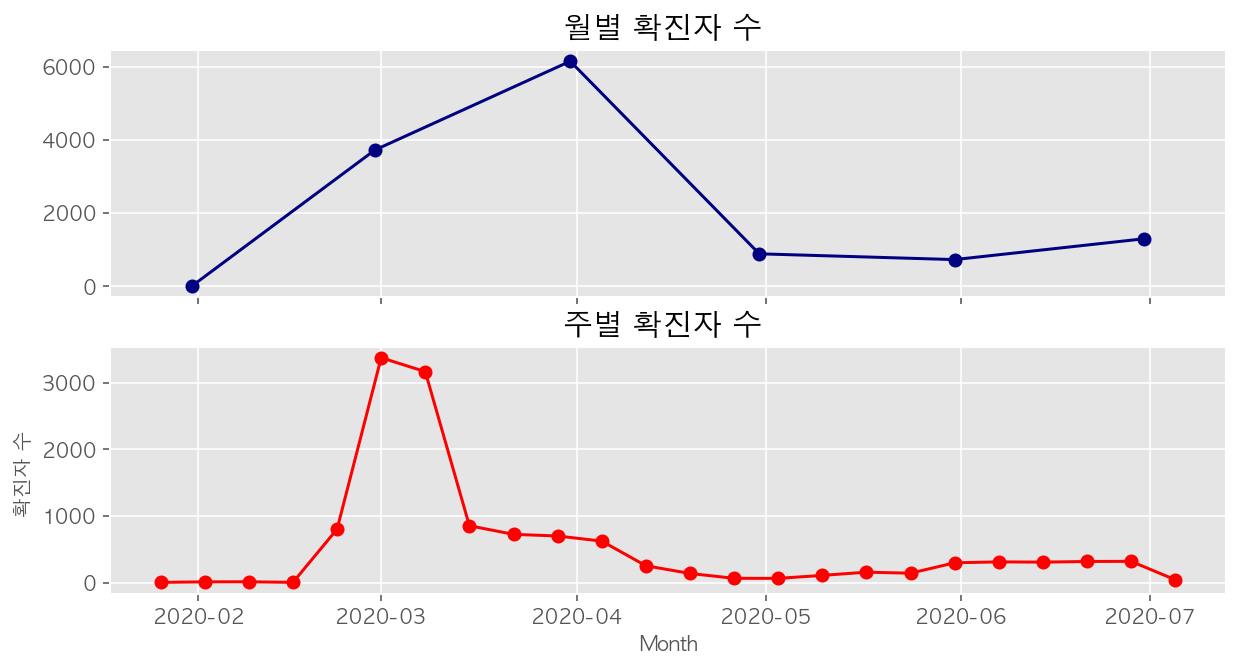

In [41]:
df3= pd.DataFrame()
df3['월별 확진자 수'] = m
df3

df4= pd.DataFrame()
df4['주별 확진자 수']= t
df4


fig, ax = plt.subplots(2, 1, figsize = (10,5),sharex=True)

ax[0].set_title('월별 확진자 수 ', fontsize= 15)
ax[0].plot(df3.index,df3['월별 확진자 수'], marker ='o', color='navy')
plt.xlabel('Month', fontsize=10)
plt.ylabel('확진자 수 ', fontsize= 10)

ax[1].set_title('주별 확진자 수', fontsize=15)
ax[1].plot(df4.index,df4['주별 확진자 수'], marker ='o', color='red')
plt.title('주별 확진자 수 ', fontsize= 15)
plt.ylabel('확진자 수 ', fontsize= 10)


plt.show()

확진자 수를 구했으니 배달총액을 구해봅시다.

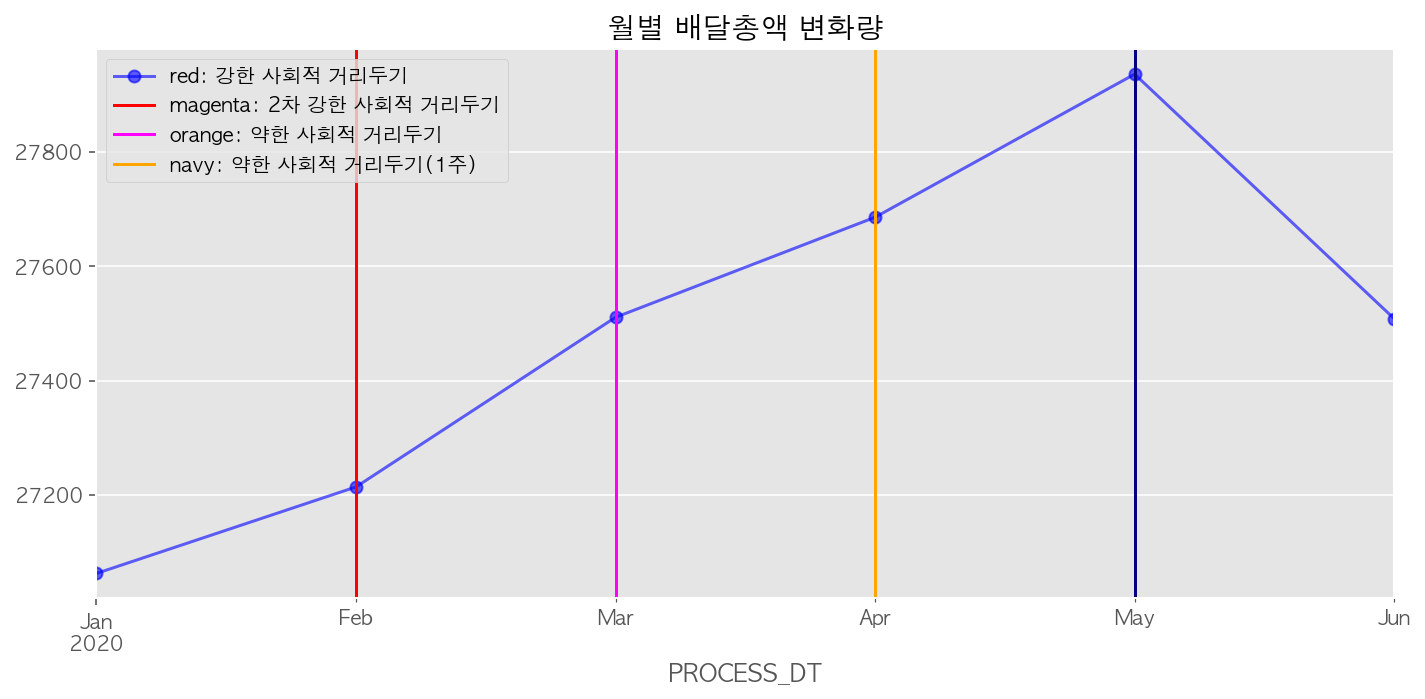

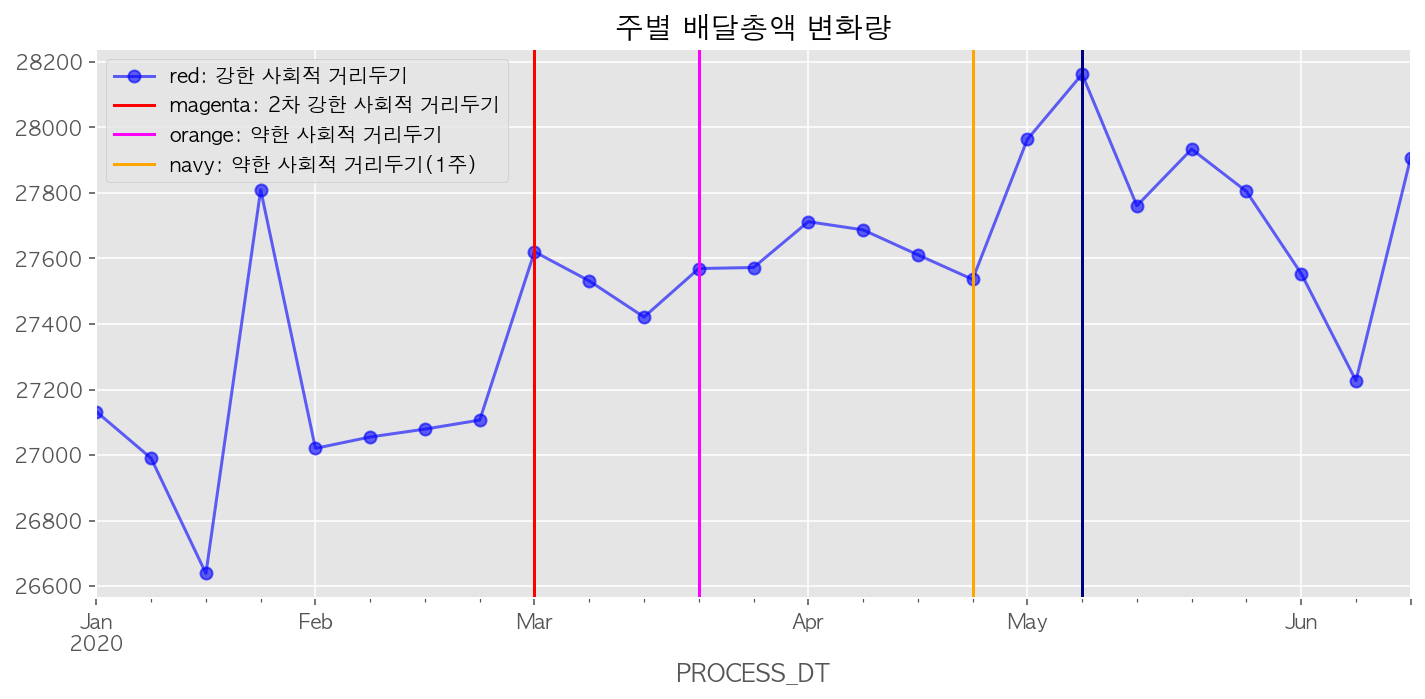

In [29]:
#배달총액 변화량(월)

%matplotlib inline 

df.plot(color='blue',alpha=0.6,figsize=(10,5),marker='o')
plt.style.use('ggplot')
plt.title("월별 배달총액 변화량")

plt.axvline(x='2020-02-29',color='red')
plt.axvline(x='2020-03-22',color='magenta', linestyle='-')
plt.axvline(x='2020-04-20', color='orange')
plt.axvline(x='2020-05-06', color='navy')

plt.legend(['red: 강한 사회적 거리두기', 'magenta: 2차 강한 사회적 거리두기', 'orange: 약한 사회적 거리두기','navy: 약한 사회적 거리두기(1주)'])


plt.tight_layout()
plt.show()

#배달총액 변화량(주)

df2.plot(color='blue',alpha=0.6,figsize=(10,5),marker='o')
plt.style.use('ggplot')
plt.title("주별 배달총액 변화량")

plt.axvline(x='2020-02-29',color='red')
plt.axvline(x='2020-03-22',color='magenta', linestyle='-')
plt.axvline(x='2020-04-20', color='orange')
plt.axvline(x='2020-05-06', color='navy')

plt.legend(['red: 강한 사회적 거리두기', 'magenta: 2차 강한 사회적 거리두기', 'orange: 약한 사회적 거리두기','navy: 약한 사회적 거리두기(1주)'])


plt.tight_layout()
plt.show()


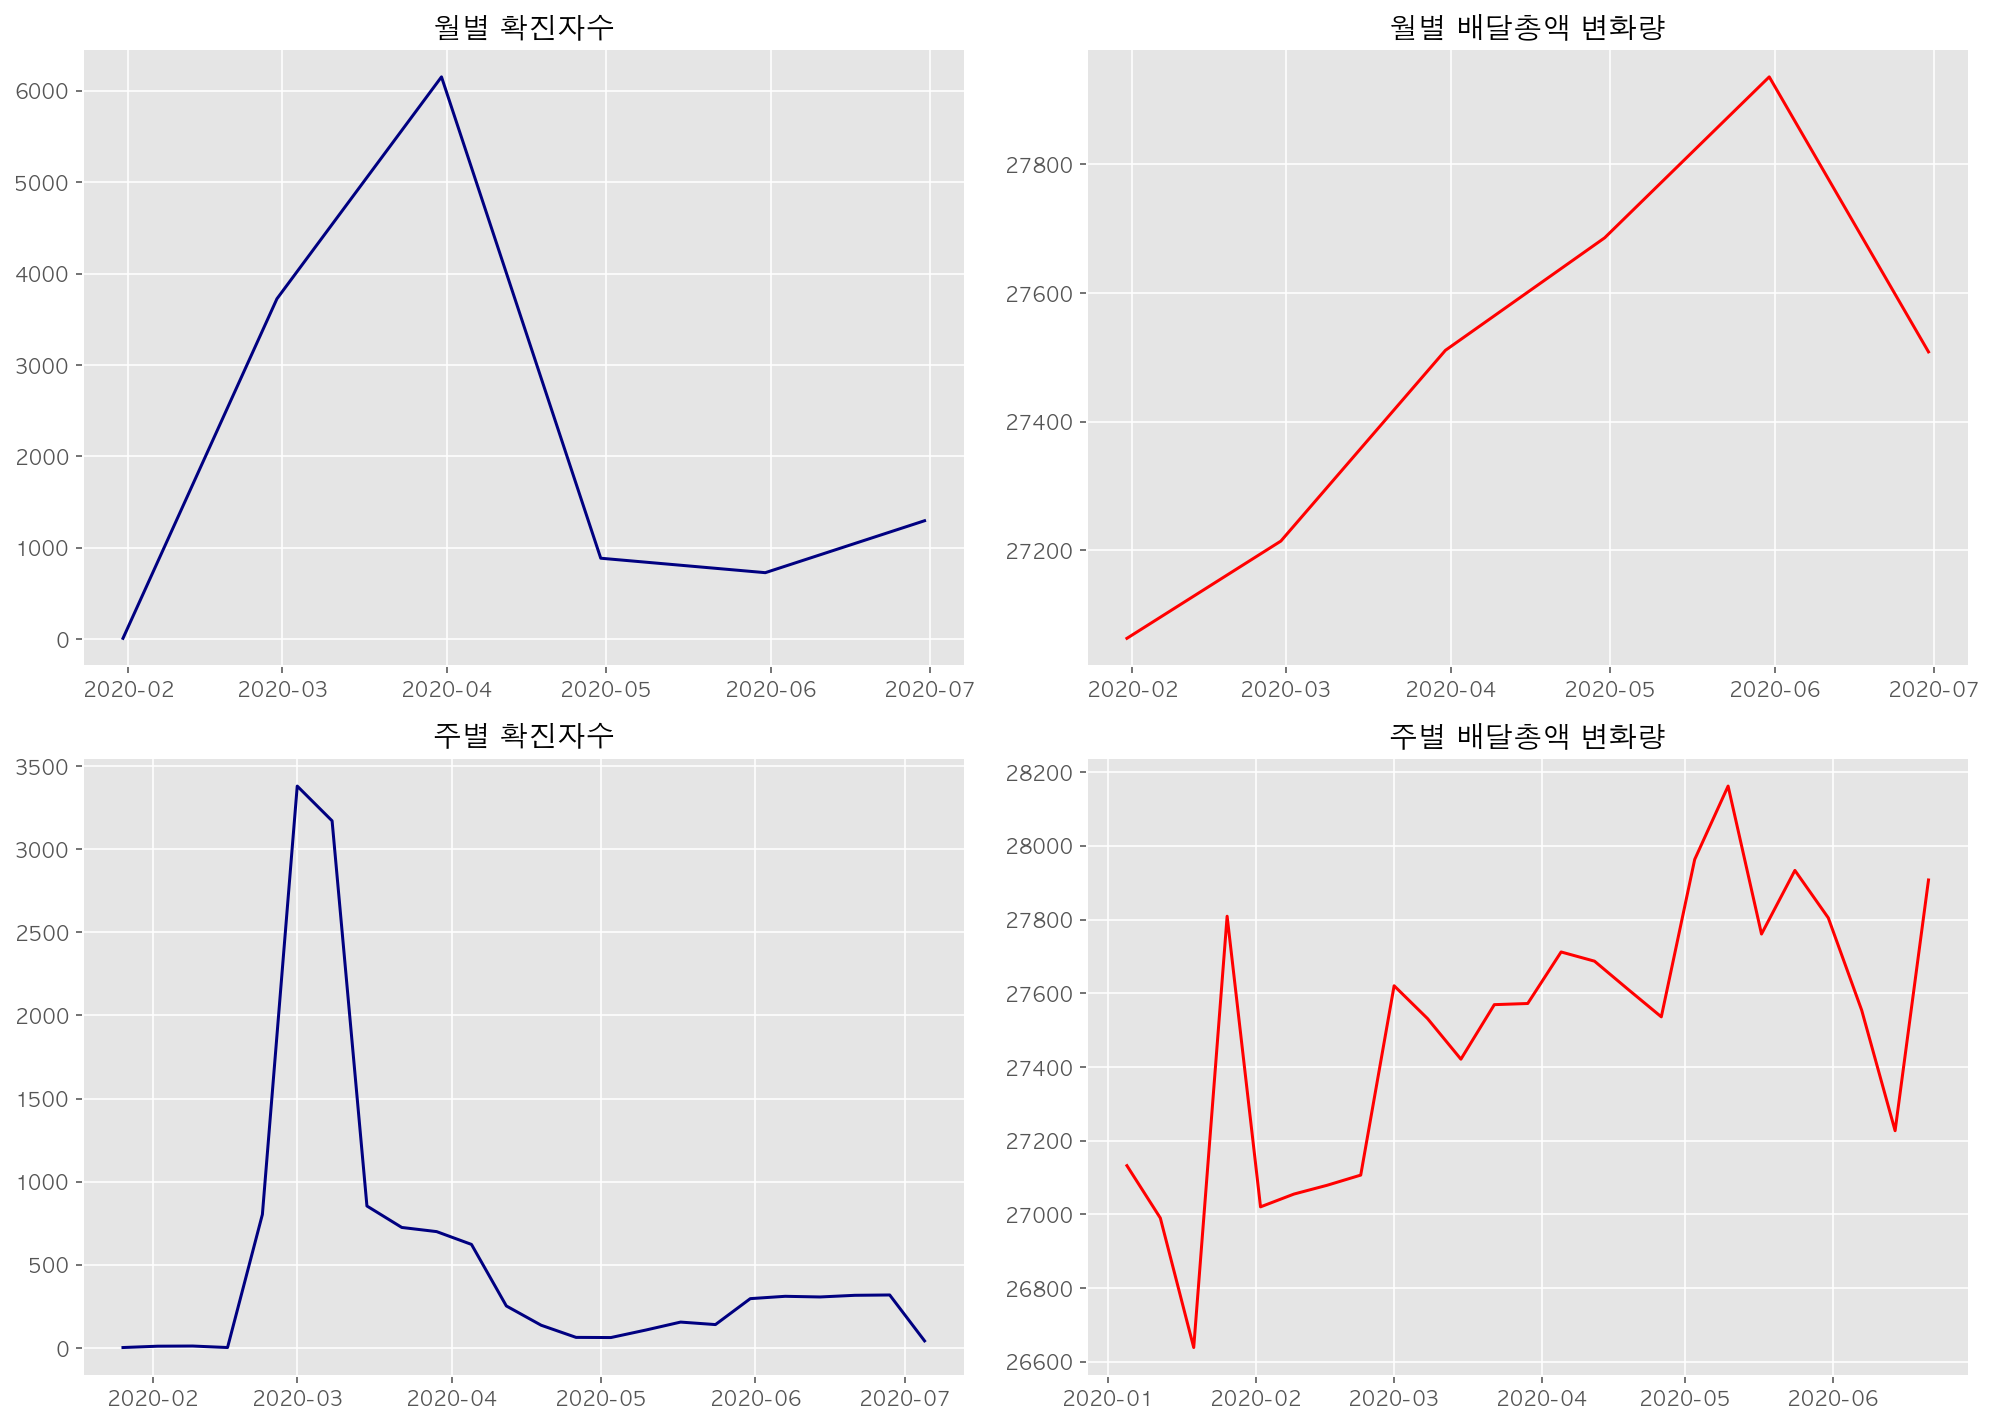

In [42]:
#배달 변화량과 확진자수 변화량

plt.rcParams["figure.figsize"] = (14,10)
plt.style.use('ggplot')
#월 별
plt.subplot(221)
plt.plot(df.index, m, color='navy')
plt.title("월별 확진자수")
plt.subplot(222)
plt.plot(df.index,y, color='red')
plt.title("월별 배달총액 변화량")

#주 별
plt.subplot(223)
plt.plot(df4.index,t, color='navy' )
plt.title("주별 확진자수")

plt.subplot(224)
plt.plot(z, color='red')
plt.title("주별 배달총액 변화량")

plt.tight_layout()
plt.show()


확진자수가 늘었다고 해서 배달 총액 (배달 시장)이 늘은 것은 아닌 것으로 파악했습니다. 또한 사회적 거리두기가 늘었다고 해서 사람들이 배달을 더 많이 시켜먹은 것도 아니었습니다. 

그렇다면 확진자수가 많은 지역에서는 과연 배달을 더 많이 시켜먹었을지의 연관성을 배달총매출을 활용하여 살펴보려 합니다. 인구수 데이터를 통해 지역별 배달총매출을 인구로 나누어 인당으로 배달비를 구해보았습니다. 

In [43]:
delivery['amount'] = delivery['DLVR_AMOUNT']+ delivery['CALL_RLAY_FEE_AMOUNT']+delivery['GOODS_AMOUNT']
delivery_amount = delivery.groupby('DLVR_DSTN_SIDO').amount.sum()
delivery_amount =delivery_amount.sort_values(ascending=False) 
delivery_amount

DLVR_DSTN_SIDO
경기도        75667735053
서울특별시      22097510930
경상남도        7373880546
경상북도        4835946677
충청남도        4554932847
전라북도        3743435422
인천광역시       2886261357
충청북도        2561932281
제주특별자치도     1676643920
대전광역시       1576029179
대구광역시       1467521332
전라남도         914427394
부산광역시        733156059
강원도          289750899
광주광역시        237853730
울산광역시           133200
Name: amount, dtype: int64

In [44]:
living = pd.read_csv("./Data_KT/living.csv",thousands = ',')
living = living.set_index("행정구역(시군구)별")
living = living.tail(-1)
living.mean()


1월    3.219074e+06
2월    3.218802e+06
3월    3.218650e+06
4월    3.218582e+06
5월    3.218500e+06
6월    3.218379e+06
dtype: float64

In [45]:
DAR = pd.concat([delivery_amount, living], axis=1)
# DAR= delivery_amount_ratio

DAR['1인당 배달음식 지출'] = DAR['amount']/DAR.mean(axis=1)

DAR

,amount,1월,2월,3월,4월,5월,6월,1인당 배달음식 지출
경기도,75667735053,13250368,13265377,13288975,13311254,13324041,13338020,6.992628
서울특별시,22097510930,9733509,9736962,9733655,9726787,9724496,9720846,6.981556
경상남도,7373880546,3361344,3358828,3355341,3353380,3351347,3349454,6.980943
경상북도,4835946677,2662508,2658956,2653418,2651054,2648760,2646493,6.977030
충청남도,4554932847,2122455,2120995,2119749,2118457,2118510,2119771,6.980506
전라북도,3743435422,1817302,1815112,1812936,1811619,1810097,1808802,6.979722
인천광역시,2886261357,2956119,2954955,2952689,2950972,2950063,2947217,6.957305
충청북도,2561932281,1599391,1598599,1597639,1596613,1596710,1597593,6.973904
제주특별자치도,1676643920,670749,670876,670508,670595,670793,671316,6.983237
대전광역시,1576029179,1474152,1473125,1471858,1471650,1471915,1471040,6.960983


In [46]:
import math

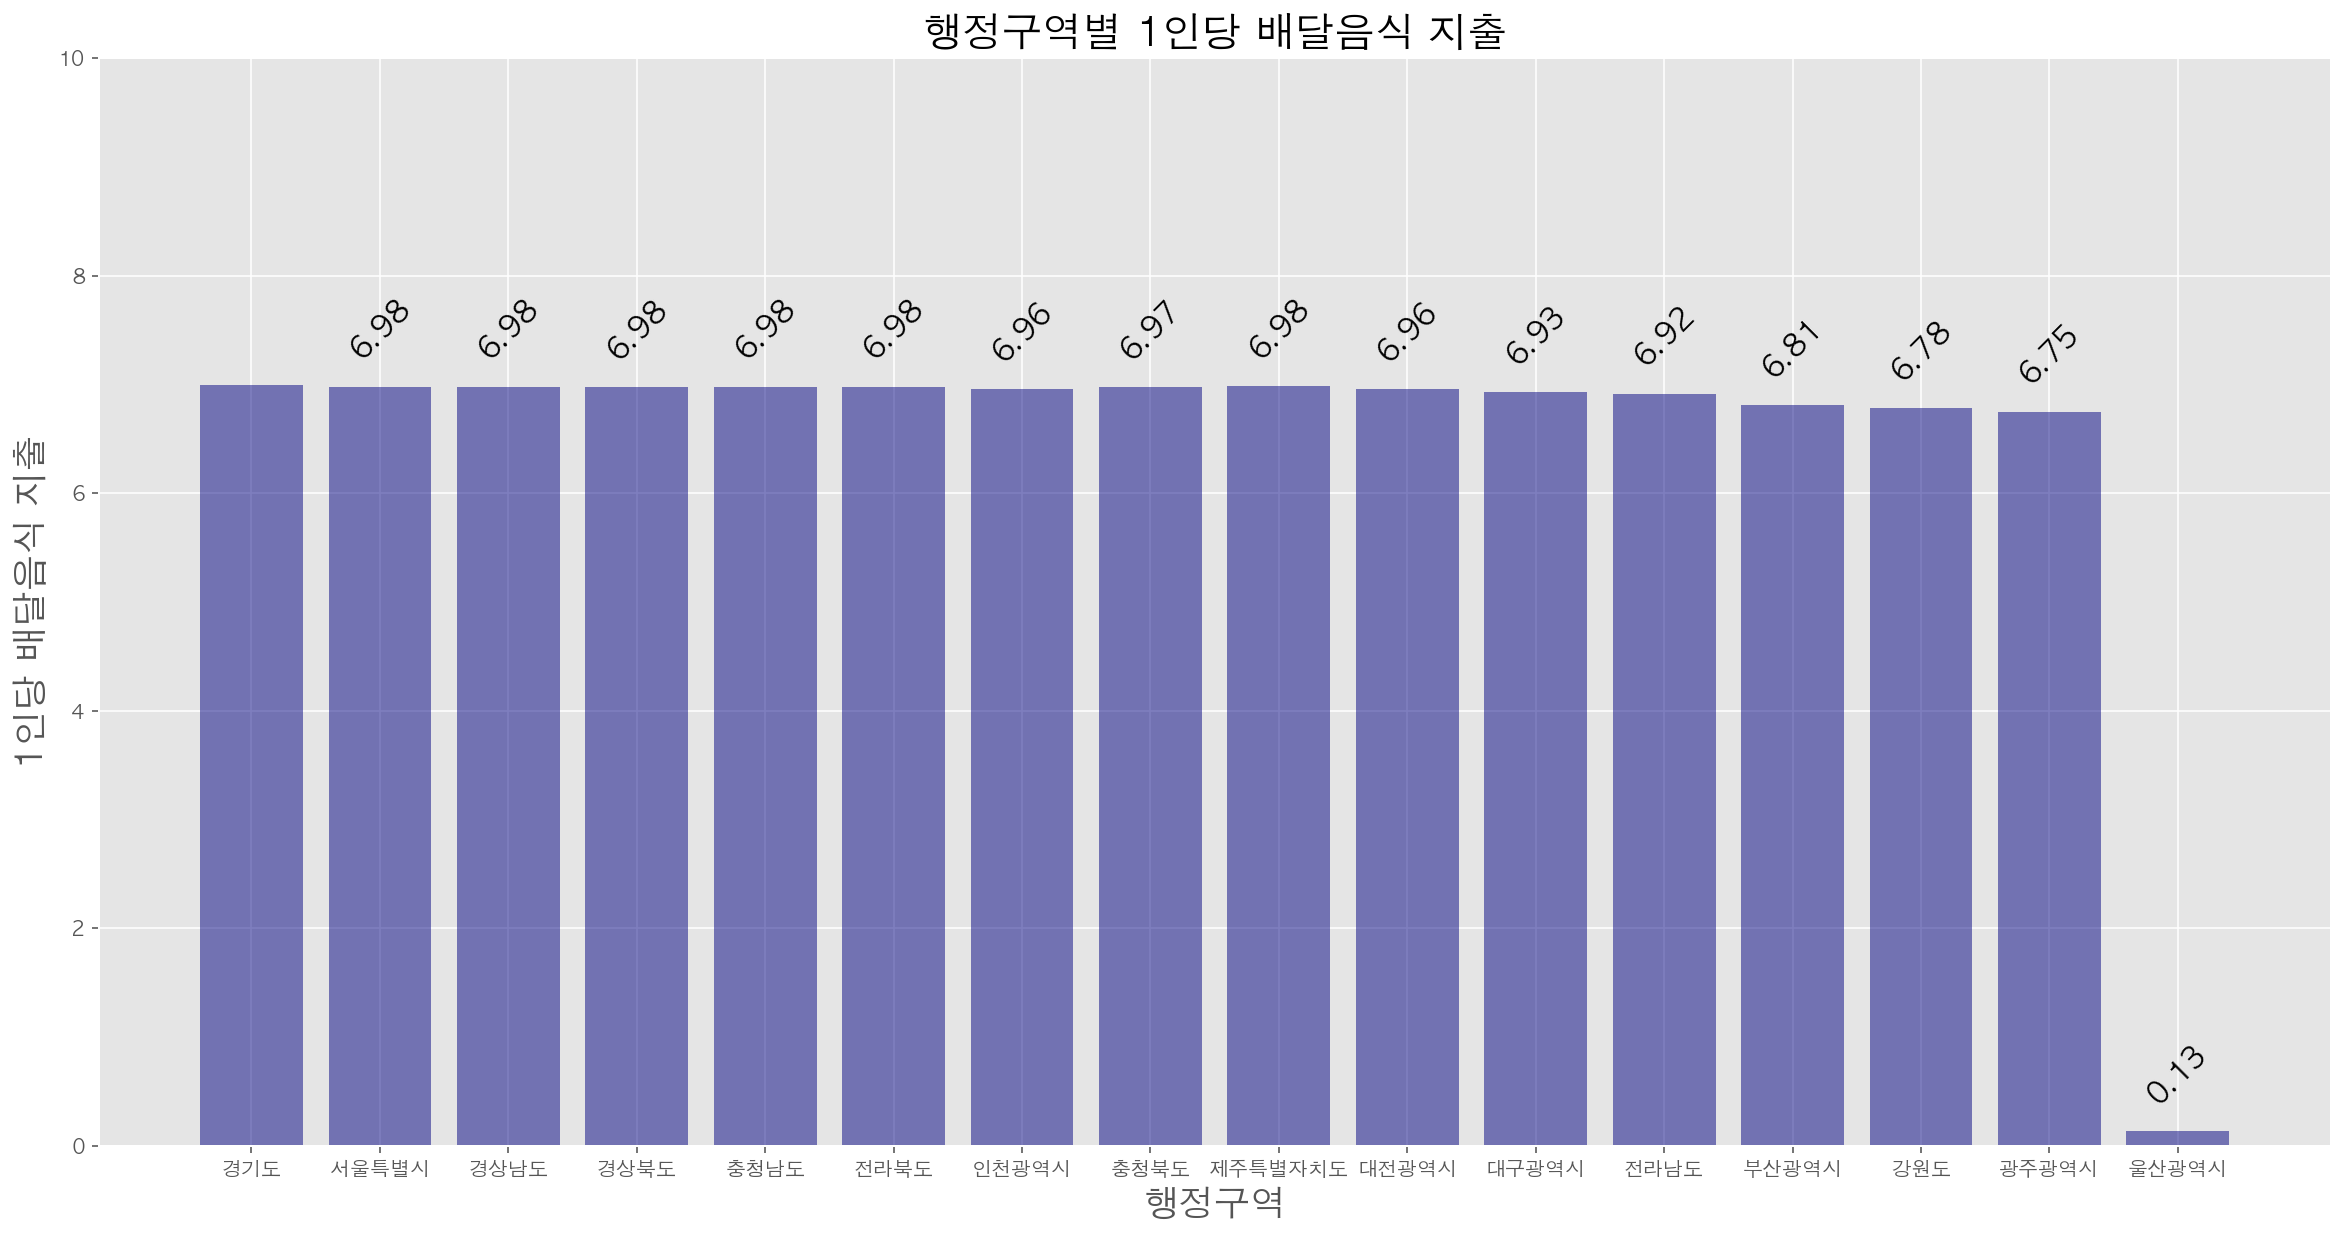

In [47]:

plt.figure(figsize=(20, 10))
plt.style.use('ggplot')
plt.bar(DAR.index, DAR['1인당 배달음식 지출'], alpha=0.5, color='navy')
plt.title('행정구역별 1인당 배달음식 지출', fontsize=20)
plt.ylim(0,10)

for i in range(15):
    plt.text(DAR.index[i+1],DAR['1인당 배달음식 지출'][i+1]+0.2,round(DAR['1인당 배달음식 지출'][i+1],2), 
             fontsize=15, color= 'black', horizontalalignment='center', verticalalignment='bottom',rotation=45)


plt.xlabel('행정구역', fontsize=18)
plt.ylabel('1인당 배달음식 지출', fontsize=18)


#plt.xticks(index, DAR['1인당 배달음식 지출'], fontsize=15)
plt.show()


확진자 수가 많은 지역에 배달음식지출이 많으려면 대구나 서울권에 배달음식 지출이 많아야하지만, 꼭 그렇지도 않습니다. 큰 상관관계가 없어 보입니다. 

한편, 코로나로 인해 평소 배달해먹지 않는 음식들의 배달건수가 늘었을 것이라 예상했습니다. 그 중 가장 대표적인 것이 아시안/양식, 카페/디저트라 생각되어 평소에도 많이 시켜먹는 치킨(통계적으로 한국인이 가장 많이 먹는 야식 1위라고 합니다) 과 그 둘을 비교해보려합니다.

In [86]:
delivery

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,...,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,amount
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,...,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN,29590
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,...,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN,54000
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,...,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN,26600
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,...,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN,24800
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,...,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN,38800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158319,10672688,2020-06-21,C000312,1,C000312,S0029529,야식,4125010200,경기도,동두천시,...,3000,500,26000,1,승인:하나카드,2020-06-21 22:48:22,2020-06-21 22:48:37,2020-06-21 23:07:47,NaN,29500
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,...,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN,25655
5158321,10672690,2020-06-21,C000130,1,C000130,S0042234,야식,4128112300,경기도,고양시 덕양구,...,3000,300,17000,2,NaN,2020-06-21 22:55:08,2020-06-21 22:55:22,2020-06-21 23:14:45,NaN,20300
5158322,10672691,2020-06-21,C000237,1,C000237,S0021766,족발/보쌈,4121010200,경기도,광명시,...,3630,200,53700,1,승인:비씨카드사,2020-06-21 23:10:38,2020-06-21 23:11:03,2020-06-21 23:25:10,NaN,57530


In [95]:
delivery2 = delivery.drop(['SERIAL_NUMBER','DLVR_RQESTER_ID','DLVR_REQUST_STTUS_VALUE',
                          'DLVR_RCEPT_CMPNY_ID', 'DLVR_STORE_ID', 'DLVR_STORE_LEGALDONG_CODE','DLVR_STORE_SIDO'
                          , 'DLVR_STORE_SIGUNGU','SETLE_KND_VALUE', 'SETLE_CARD_CN','DLVR_RCEPT_TIME', 'DLVR_CARALC_TIME'
                          ,'DLVR_CANCL_TIME' ],axis = 1)

delivery2['Total'] = delivery2['DLVR_AMOUNT']+ delivery2['CALL_RLAY_FEE_AMOUNT']+delivery2['GOODS_AMOUNT']
delivery2 = delivery2.set_index('DLVR_STORE_INDUTY_NM')

In [97]:
Chicken = delivery2.loc[delivery2.index == '치킨']
display(Chicken)

Cafe_Dessert = delivery2.loc[delivery2.index =='카페/디저트']
display(Cafe_Dessert)

Asian = delivery2.loc[delivery2.index =='아시안/양식']
display(Asian)

,PROCESS_DT,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,DLVR_COMPT_TIME,amount,Total
DLVR_STORE_INDUTY_NM,,,,,,,,,,,,,,,,,,,
치킨,2020-01-01,합성동,NaN,4812759000,4.812748e+11,4.812710e+09,경상남도,창원시 마산회원구,석전동,NaN,4.812754e+09,4.812748e+11,D0005271,4290,300,25000,2020-01-01 00:41:37,29590,29590
치킨,2020-01-01,갈현동,NaN,1138055100,1.138041e+11,1.138010e+09,서울특별시,은평구,갈현동,NaN,1.138055e+09,1.138041e+11,D0001536,3300,300,23000,2020-01-01 00:18:47,26600,26600
치킨,2020-01-01,대림동,NaN,1156070000,1.156042e+11,1.156013e+09,서울특별시,영등포구,신길동,NaN,1.156052e+09,1.156031e+11,D0006259,4800,200,17000,2020-01-01 01:23:41,22000,22000
치킨,2020-01-01,광양읍,인서리,4623025000,4.623047e+11,4.623025e+09,전라남도,광양시,광양읍,용강리,4.623025e+09,4.623047e+11,D0006823,3300,300,19000,2020-01-01 00:22:54,22600,22600
치킨,2020-01-01,두산동,NaN,2726064000,2.726042e+11,2.726011e+09,대구광역시,수성구,지산동,NaN,2.726065e+09,2.726042e+11,D0006876,3000,300,18000,2020-01-01 00:24:14,21300,21300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
치킨,2020-06-21,의정부동,NaN,4115052000,4.115032e+11,4.115010e+09,경기도,의정부시,호원동,NaN,4.115054e+09,4.115032e+11,D0009395,5000,300,17000,2020-06-21 23:11:26,22300,22300
치킨,2020-06-21,화정동,NaN,4128162200,4.128132e+11,4.128111e+09,경기도,고양시 덕양구,성사동,NaN,4.128154e+09,4.128144e+11,D0002413,5500,300,24400,2020-06-21 23:31:22,30200,30200
치킨,2020-06-21,나운동,NaN,4513070100,4.513033e+11,4.513014e+09,전라북도,군산시,지곡동,NaN,4.513069e+09,4.513046e+11,D0011833,4000,600,20900,2020-06-21 23:43:56,25500,25500


,PROCESS_DT,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,DLVR_COMPT_TIME,amount,Total
DLVR_STORE_INDUTY_NM,,,,,,,,,,,,,,,,,,,
카페/디저트,2020-01-01,지산동,NaN,4122056000,4.122032e+11,4.122011e+09,경기도,평택시,지산동,NaN,4.122055e+09,4.122032e+11,D0007182,3500,300,15900,2020-01-01 01:24:49,19700,19700
카페/디저트,2020-01-01,지산동,NaN,4122056000,4.122032e+11,4.122011e+09,경기도,평택시,독곡동,NaN,4.122056e+09,4.122044e+11,D0007182,3500,300,20700,2020-01-01 01:24:47,24500,24500
카페/디저트,2020-01-01,철산동,NaN,4121060000,4.121032e+11,4.121010e+09,경기도,광명시,철산동,NaN,4.121060e+09,4.121032e+11,D0004012,3800,200,16500,2020-01-01 01:00:18,20500,20500
카페/디저트,2020-01-01,철산동,NaN,4121060000,4.121032e+11,1.153011e+09,서울특별시,구로구,개봉동,NaN,1.153076e+09,1.153041e+11,D0005003,3800,200,17500,2020-01-01 00:44:00,21500,21500
카페/디저트,2020-01-01,지산동,NaN,4122056000,4.122032e+11,4.122010e+09,경기도,평택시,서정동,NaN,4.122052e+09,4.122032e+11,D0007182,3500,300,18400,2020-01-01 00:59:41,22200,22200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
카페/디저트,2020-06-21,읍내동,NaN,4421051000,4.421033e+11,4.421011e+09,충청남도,서산시,석림동,NaN,4.421054e+09,4.421033e+11,D0013288,3500,300,9900,2020-06-21 22:58:23,13700,13700
카페/디저트,2020-06-21,감삼동,NaN,2729055500,2.729031e+11,2.729010e+09,대구광역시,달서구,성당동,NaN,2.729052e+09,2.729042e+11,D0003333,3000,200,15500,2020-06-21 23:10:59,18700,18700
카페/디저트,2020-06-21,일산동,NaN,4213056000,4.213032e+11,4.213011e+09,강원도,원주시,행구동,NaN,4.213065e+09,4.213045e+11,D0000484,4200,0,15500,NaN,19700,19700


,PROCESS_DT,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,DLVR_COMPT_TIME,amount,Total
DLVR_STORE_INDUTY_NM,,,,,,,,,,,,,,,,,,,
아시안/양식,2020-01-01,월평동,NaN,3017058600,3.017043e+11,3.017011e+09,대전광역시,서구,월평동,NaN,3.017059e+09,3.017032e+11,D0007177,3500,100,12900,2020-01-01 00:28:42,16500,16500
아시안/양식,2020-01-01,월평동,NaN,3017058600,3.017043e+11,3.017011e+09,대전광역시,서구,월평동,NaN,3.017059e+09,3.017032e+11,D0007177,3500,100,13500,2020-01-01 01:04:10,17100,17100
아시안/양식,2020-01-01,월평동,NaN,3017058600,3.017043e+11,3.020011e+09,대전광역시,유성구,봉명동,NaN,3.020053e+09,3.020020e+11,D0007177,4100,100,15400,2020-01-01 01:18:06,19600,19600
아시안/양식,2020-01-01,이동,NaN,4127151500,4.127144e+11,4.127110e+09,경기도,안산시 상록구,이동,NaN,4.127152e+09,4.127144e+11,D0004641,3000,200,13500,2020-01-01 11:21:42,16700,16700
아시안/양식,2020-01-01,행신동,NaN,4128165000,4.128144e+11,4.128111e+09,경기도,고양시 덕양구,동산동,NaN,4.128158e+09,4.128132e+11,D0002322,6500,300,43200,2020-01-01 11:55:52,50000,50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
아시안/양식,2020-06-21,심곡동,NaN,4119060300,4.119032e+11,4.119011e+09,경기도,부천시,상동,NaN,4.119074e+09,4.119032e+11,D0009264,5300,200,17500,2020-06-21 23:00:08,23000,23000
아시안/양식,2020-06-21,심곡동,NaN,4119060300,4.119032e+11,4.119011e+09,경기도,부천시,중동,NaN,4.119074e+09,4.119032e+11,D0013008,4300,300,20500,2020-06-21 23:40:03,25100,25100
아시안/양식,2020-06-21,심곡동,NaN,4119060300,4.119032e+11,4.119011e+09,경기도,부천시,심곡본동,NaN,4.119075e+09,4.119044e+11,D0013059,3300,200,14000,2020-06-21 23:22:57,17500,17500


In [98]:
idx_nw= pd.to_datetime(Chicken['PROCESS_DT'])
b = list(Chicken['Total'])
ts_chicken = Series(b, idx_nw)
display(ts_chicken)

idx_nw2= pd.to_datetime(Cafe_Dessert['PROCESS_DT'])
c= list(Cafe_Dessert['Total'])
ts_dessert = Series(c, idx_nw2)
display(ts_dessert)

idx_nw3= pd.to_datetime(Asian['PROCESS_DT'])
d= list(Asian['Total'])
ts_asian = Series(d, idx_nw3)
display(ts_asian)



PROCESS_DT
2020-01-01    29590
2020-01-01    26600
2020-01-01    22000
2020-01-01    22600
2020-01-01    21300
              ...  
2020-06-21    22300
2020-06-21    30200
2020-06-21    25500
2020-06-21    21000
2020-06-21    27000
Length: 1173238, dtype: int64

PROCESS_DT
2020-01-01    19700
2020-01-01    24500
2020-01-01    20500
2020-01-01    21500
2020-01-01    22200
              ...  
2020-06-21    13700
2020-06-21    18700
2020-06-21    19700
2020-06-21    19400
2020-06-21    23800
Length: 457830, dtype: int64

PROCESS_DT
2020-01-01    16500
2020-01-01    17100
2020-01-01    19600
2020-01-01    16700
2020-01-01    50000
              ...  
2020-06-21    23000
2020-06-21    25100
2020-06-21    17500
2020-06-21    16500
2020-06-21    19260
Length: 109185, dtype: int64

In [99]:
chicken_resample_M = ts_chicken.resample('M').sum()
chicken_resample_M

chicken_resample_W = ts_chicken.resample('W').sum()
chicken_resample_W

Caffe_resample_M = ts_dessert.resample('M').sum()
Caffe_resample_W = ts_dessert.resample('W').sum()


Asian_resample_M = ts_asian.resample('M').sum()
Asian_resample_W = ts_asian.resample('W').sum()

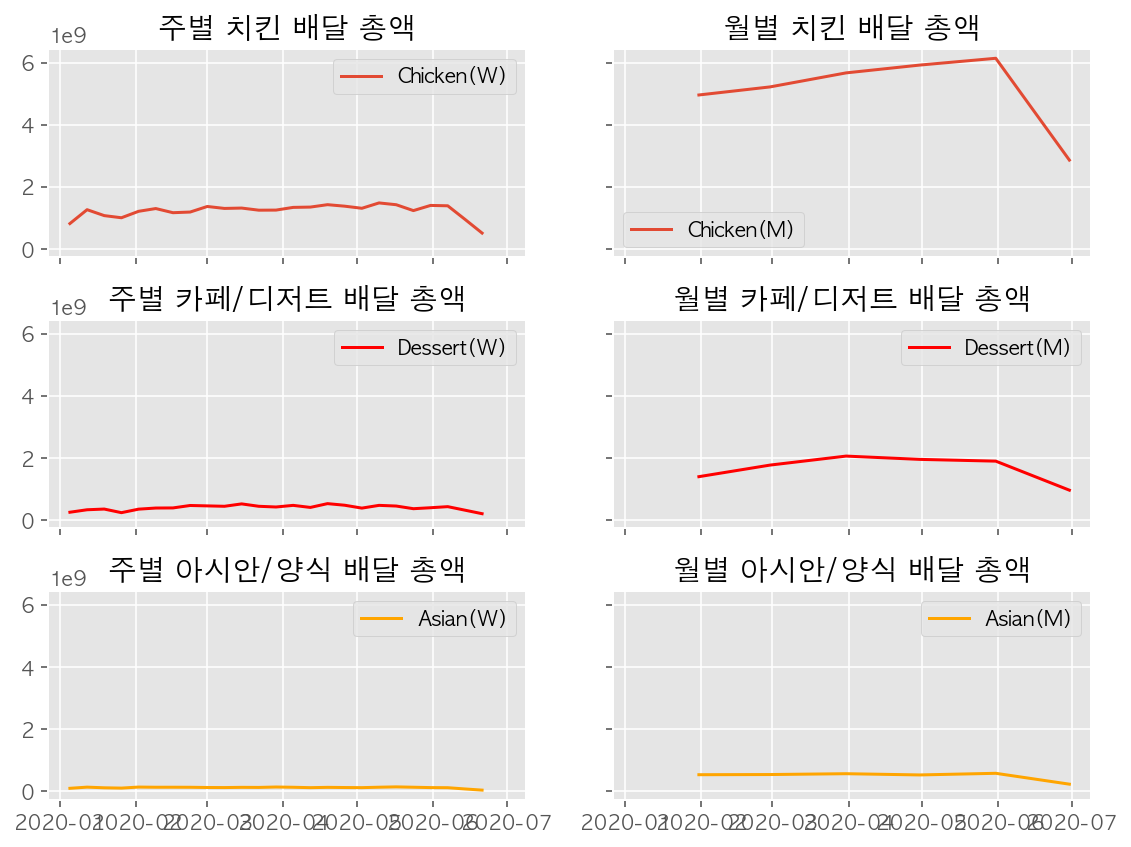

In [100]:
df_chicken= pd.DataFrame()
df_chicken['주별 치킨 배달 총액'] = chicken_resample_W
df_chicken_M= pd.DataFrame()
df_chicken_M['월별 치킨 배달 총액'] = chicken_resample_M

df_caffe_M = pd.DataFrame()
df_caffe_M['월별 카페/디저트 배달 총액'] = Caffe_resample_M
df_caffe = pd.DataFrame()
df_caffe['주별 카페/디저트 배달 총액'] = Caffe_resample_W
 

df_asian_M = pd.DataFrame()
df_asian_M['월별 아시안/양식 배달 총액'] = Asian_resample_M
df_asian = pd.DataFrame()
df_asian['주별 아시안/양식 배달 총액'] = Asian_resample_W
    
fig, ax = plt.subplots(3, 2,figsize=(8,6),sharex=True, sharey=True)
ax[0,0].plot(df_chicken.index,df_chicken['주별 치킨 배달 총액'],label='Chicken(W)')
ax[0,1].plot(df_chicken_M.index,df_chicken_M['월별 치킨 배달 총액'], label='Chicken(M)')
ax[1,0].plot(df_caffe.index, df_caffe['주별 카페/디저트 배달 총액'],label='Dessert(W)',color='red')
ax[1,1].plot(df_caffe_M.index, df_caffe_M['월별 카페/디저트 배달 총액'],label='Dessert(M)',color='red')
ax[2,0].plot(df_asian.index,df_asian['주별 아시안/양식 배달 총액'],label='Asian(W)',color='orange')
ax[2,1].plot(df_asian_M.index,df_asian_M['월별 아시안/양식 배달 총액'],label='Asian(M)',color='orange')

ax[0,0].set_title('주별 치킨 배달 총액')
ax[0,1].set_title('월별 치킨 배달 총액')
ax[1,0].set_title('주별 카페/디저트 배달 총액')
ax[1,1].set_title('월별 카페/디저트 배달 총액')
ax[2,0].set_title('주별 아시안/양식 배달 총액')
ax[2,1].set_title('월별 아시안/양식 배달 총액')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[2, 0].legend()
ax[2, 1].legend()


plt.tight_layout()
plt.show()



요런식으로도 표현할 수 있습니다. 

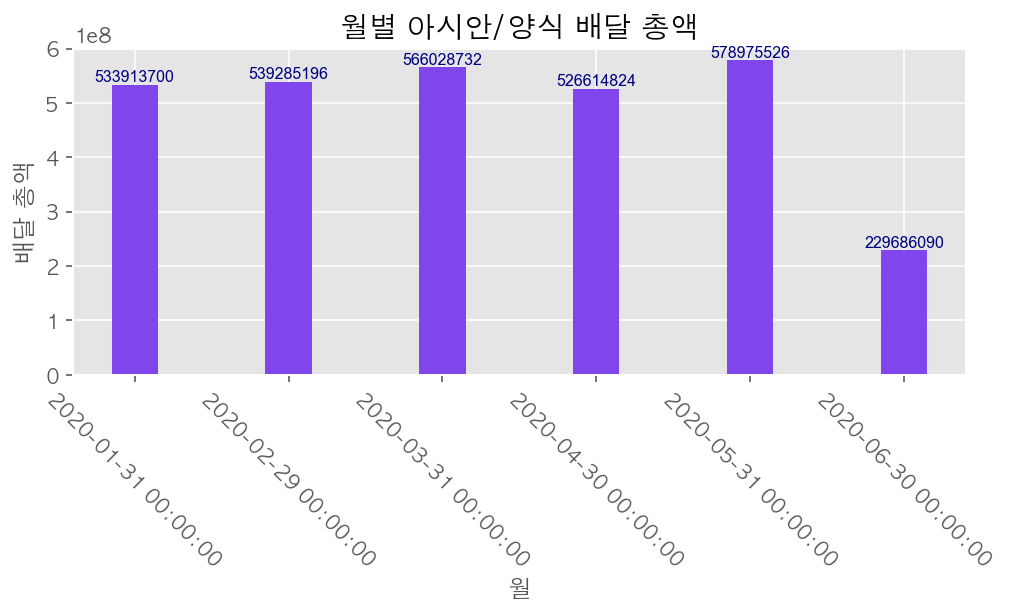

In [101]:
plt.rcParams['font.family'] = 'AppleGothic'

display(df_asian_M['월별 아시안/양식 배달 총액'].plot.bar(color='#8046eb', rot=0, width=0.3,figsize = (8,3)))
plt.ylim(0, 600000000)

plt.title("월별 아시안/양식 배달 총액")
plt.xlabel("월")
plt.ylabel("배달 총액")   
plt.xticks(rotation=-45)
plt.style.use('seaborn')
for x, y in enumerate( list(df_asian_M['월별 아시안/양식 배달 총액']) ):
    txt = "%d" % y
    plt.text(x, y, txt, fontsize=8, color='navy', 
                    horizontalalignment='center', verticalalignment='bottom')

이 세 음식 종류의 배달총액 증감율을 따져보려고 합니다. 

In [102]:
#셋의 배달총액 증감율을 보려고 합니다. 

A_for_change_chicken= list(chicken_resample_M)
A_for_change_dessert = list(Caffe_resample_M)
A_for_change_asian = list(Asian_resample_M)


lst_change_c =[]
for i in range(len(A_for_change_chicken)-2):
    diff = (A_for_change_chicken[i+1] - A_for_change_chicken[i])/ A_for_change_chicken[i]
    diff = diff*100
    i +=1
    print(diff)
    lst_change_c.append(diff)
    
lst_change_c


lst_change_d =[]
for i in range(len(A_for_change_dessert)-2):
    diff = (A_for_change_dessert[i+1] -A_for_change_dessert[i])/ A_for_change_dessert[i]
    diff = diff*100
    i +=1
    print(diff)
    lst_change_d.append(diff)

lst_change_asian =[]
for i in range(len(A_for_change_asian)-2):
    diff = (A_for_change_asian[i+1] -A_for_change_asian[i])/ A_for_change_asian[i]
    diff = diff*100
    i +=1
    print(diff)
    lst_change_asian.append(diff)
    

5.233016445684927
8.651712414532547
4.432467681766704
3.6959235334763982
26.619323286963372
16.34349431524866
-5.1351002580934075
-2.8985170056300054
1.0060607173031897
4.959071044108542
-6.963234509445361
9.94288417524684


In [103]:
dfdf = pd.DataFrame()
dfdf['Asian']=lst_change_asian
dfdf['Dessert/Cafe'] =lst_change_d
dfdf['Chicken'] = lst_change_c

dfdf

,Asian,Dessert/Cafe,Chicken
0,1.006061,26.619323,5.233016
1,4.959071,16.343494,8.651712
2,-6.963235,-5.135100,4.432468
3,9.942884,-2.898517,3.695924


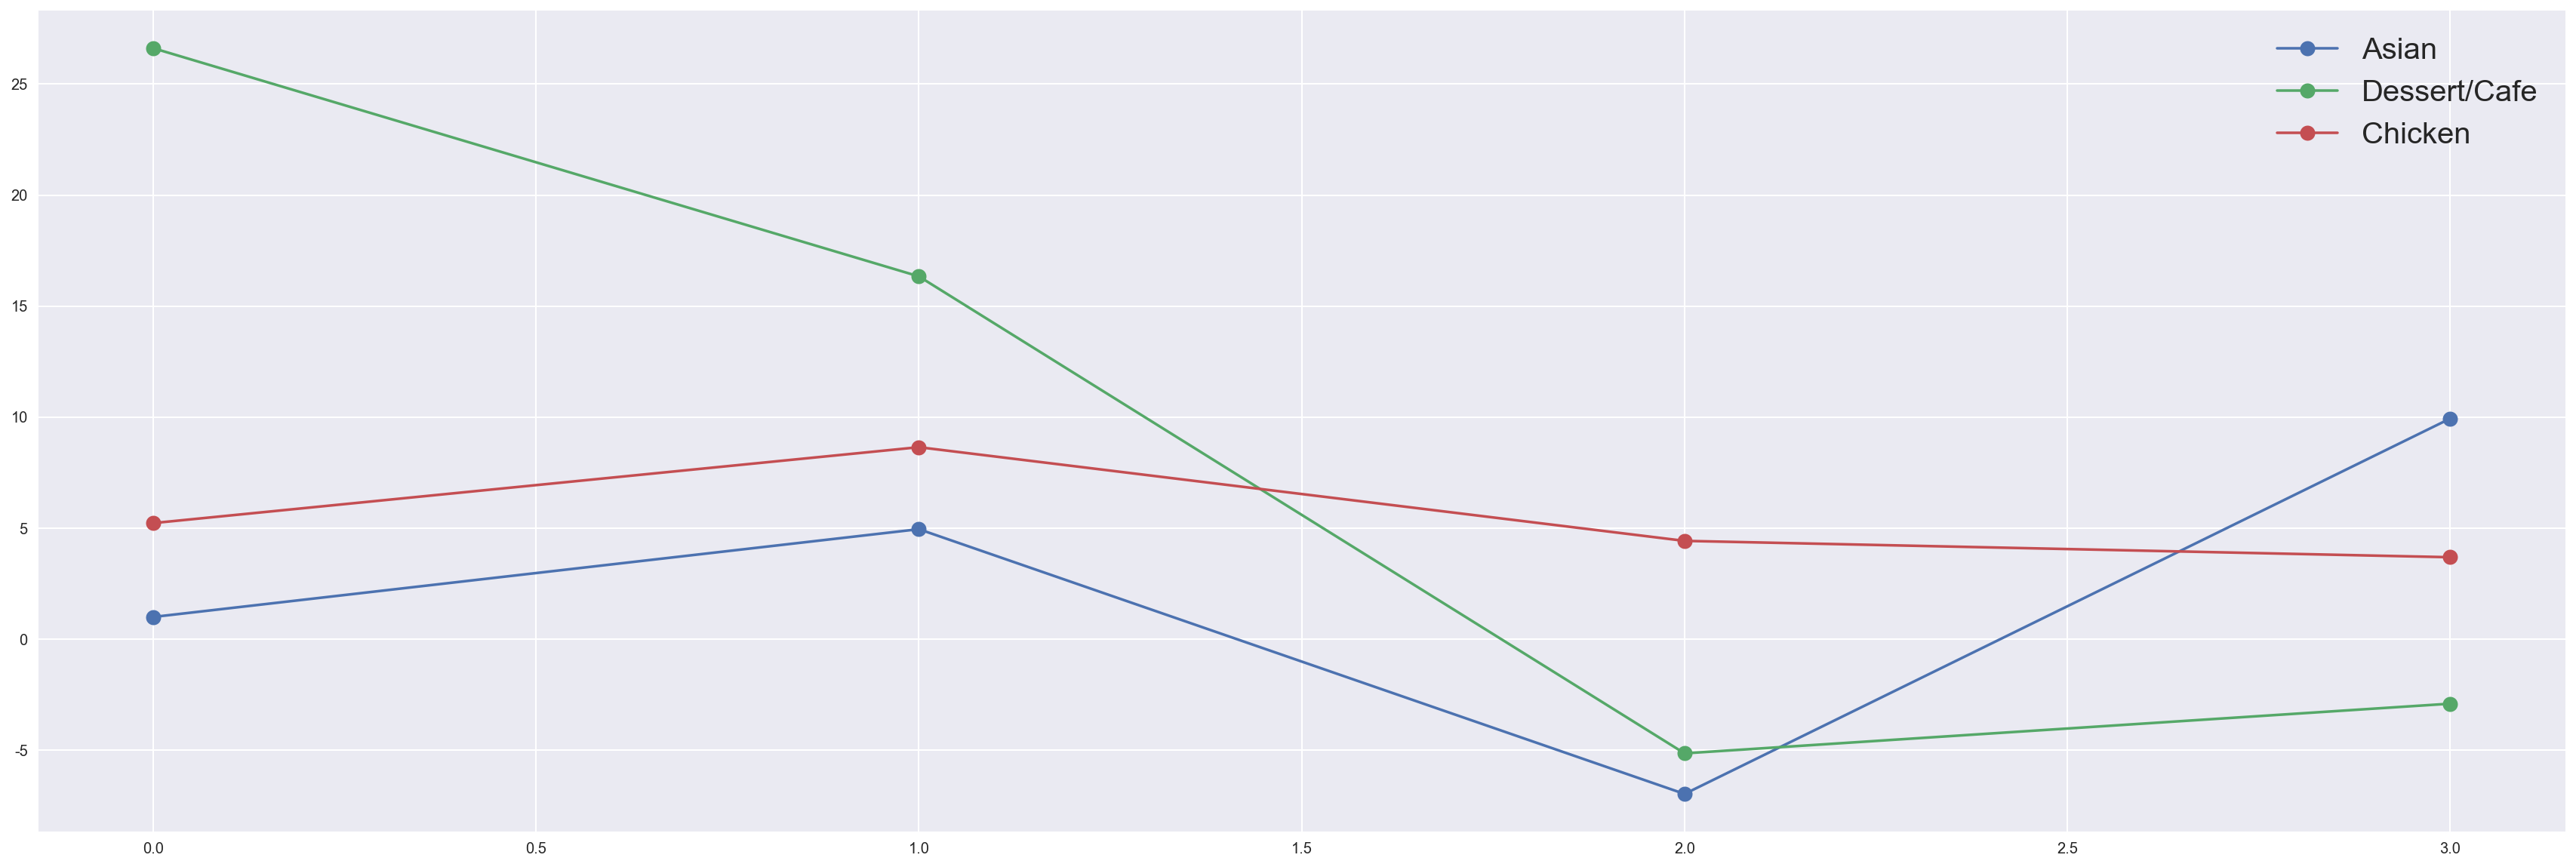

In [104]:
plt.figure(figsize=(30,10))
plt.plot(dfdf,marker='o',markersize=10)
warnings.filterwarnings(action='ignore')
plt.style.use('seaborn')
plt.legend(['Asian', 'Dessert/Cafe', 'Chicken'], fontsize=20)

plt.show()

치킨이나 아시안/양식에 비해 디저트/카페 종류가 코로나 첫 달 가장 높은 배달매출 상승률을 보였습니다. 이는 외출 시 자주 소비하는 카페/디저트류를 소비하지 못해 생긴 현상이라고 추측할 수 있습니다. 하지만 코로나가 위기 사태를 한 고비 넘기고 사람들이 다시 외출하기 시작하면서 하락세를 보이고 있습니다. 치킨의 경우엔 코로나든 아니든 자주 먹으니 큰 영향이 없겠죠.

세 음식 중 앞으로 더 유망한, 사람들이 지속될 코로나 시국에서 치킨과 카페/디저트 중 무엇일지 Fbprophet으로 예측해보았습니다.  

In [106]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
df_chickenfb = pd.DataFrame()
df_chickenfb = ts_chicken.to_frame()
df_chickenfb= df_chickenfb.reset_index()
df_chickenfb.columns= ['ds','y']

df_caffefb = pd.DataFrame()
df_caffefb= ts_dessert.to_frame()
df_caffefb= df_caffefb.reset_index()
df_caffefb.columns= ['ds','y']

df_chickenfb
df_caffefb

In [ ]:
chickenfb = Prophet()
chickenfb.fit(df_chickenfb)
future_ch = chickenfb.make_future_dataframe(periods=365)

caffefb =Prophet()
caffefb.fit(df_caffefb)
future_caffe = caffefb.make_future_dataframe(periods=365)

forecast_makeup = chickenfb.predict(future_ch)
forecast_makeup = m.predict(future_caffe)

fig_ch = chickenfb.plot(forecast_makeup)
fig_caffe= caffefb.plot(forecast_health)

fig2_chicken= chickenfb.plot_components(forecast_makeup)
plt.title('치킨 배달 매출 예측')
plt.show()

fig3_caffe = caffefb.plot_components(forecast_health)
plt.title('카페/디저트 배달 매출 예측')
plt.show()